## <center>Проект: Оптимизация маркетинговых затрат сервиса Х <br>
---

<article id="back">
<h2>Навигация
</article>   
<br><a href="#part0.0">Задача</a>
<br><a href="#part1">Шаг 1. Загрузка и подготовка данных</a>
<br><a href="#part2">Шаг 2. Построение отчетов отчёты и расчет метрик</a>
<br><a href="#part21">Шаг 2.1 Продукт</a>
<br><a href="#part22">Шаг 2.2 Продажи</a>
<br><a href="#part23">Шаг 2.3 Маркетинг</a>
<br><a href="#part3">Шаг 3. Общий вывод</a>


<article id="part0.0">
<h2>Задача
</article>

Изучить как люди пользуются сервисом, сколько денег приносит каждый клиент и когда окупается, в какие рекламные источники/платформы вкладывать деньги?

<a href="#back">В начало</a>

<article id="part1">
<h2>Шаг 1. Загрузка данных
</article>

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np

from scipy import stats as st

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn-darkgrid')

import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
visits = pd.read_csv('/Users/thiswayup/Desktop/AG_python/YP_unit_economy/visits_log.csv')

In [3]:
orders = pd.read_csv('/Users/thiswayup/Desktop/AG_python/YP_unit_economy/orders_log.csv')

In [4]:
costs = pd.read_csv('/Users/thiswayup/Desktop/AG_python/YP_unit_economy/costs.csv')

#### Замена названий столбцов

Откорректируем "некрасивые" названия столбцов в датафреймах

In [5]:
def rename_columns(df):
    """
    Заменяет пробелы в названиях столбцов на '_' и приводит их к нижнему регистру
    """
    names = df.columns
    new_names = []
    for column in names:
        column = column.replace(' ', '_').lower()
        new_names.append(column)
    df.columns = new_names

In [6]:
rename_columns(visits)
rename_columns(orders)

#### Предобработка дат

Приведем данные к корректному формату

In [7]:
 def convert_to_date(df, columns):
    """
    Заменяет тип данных на datetime
    """
    for column in columns:
        df[column] = pd.to_datetime(df[column])

In [8]:
def add_time_info(df, columns):
    """
    Добавляет столбцы с данными о месяце, неделе, дате и времени
    """
    for column in columns:
        df[column+'_month'] = df[column].values.astype('datetime64[M]')
        df[column+"_week"] = df[column].dt.week
        df[column+'_date'] = df[column].dt.date

In [9]:
convert_to_date(visits, ['end_ts', 'start_ts'])
add_time_info(visits, ['start_ts'])

In [10]:
visits['start_ts_weekday'] = visits['start_ts'].dt.weekday
visits['start_ts_hour'] = visits['start_ts'].dt.hour

In [11]:
convert_to_date(orders, ['buy_ts'])
add_time_info(orders, ['buy_ts'])

In [12]:
convert_to_date(costs, ['dt'])
add_time_info(costs, ['dt'])

1. Столбцы с датами во всех таблицах приведены к формату дата
2. Во всех таблицах дополнительно созданы столбцы с месяцем, неделей и временем визита/покупки/затрат
3. Дополнительно в таблице visits созданы столбцы с номером дня недели и часа посещения сервиса

<a href="#back">В начало</a>

<article id="part2">
<h2>Шаг 2. Построение отчетов и расчет метрик
</article>

<article id="part21">
<h3>Шаг 2.1 Продукт
</article>

#### Сколько людей пользуются сервисом

In [13]:
#считаю кол-во уникальных посетителей в месяц/неделю/день
mau = (visits 
       .groupby(['start_ts_month'])
       .agg(unique_users = ('uid', 'nunique'))
       .reset_index()
      )
wau = (visits
       .groupby(['start_ts_week'])
       .agg(unique_users = ('uid', 'nunique'))
       .reset_index()
      )
dau = (visits
       .groupby(['start_ts_date'])
       .agg(unique_users = ('uid', 'nunique'))
       .reset_index()
      )

In [14]:
#считаю кол-во уникальных посетителей в день недели/час суток
visits_weekday = (visits
                  .groupby(['start_ts_weekday'])
                  .agg(unique_users = ('uid', 'nunique'))
                  .reset_index()
                 )
visits_hour = (visits
               .groupby(['start_ts_hour'])
               .agg(unique_users = ('uid', 'nunique'))
               .reset_index()
              )

23228 людей пользуются сервисом в месяц
5825 людей пользуются сервисом в неделю
908 людей пользуются сервисом в день


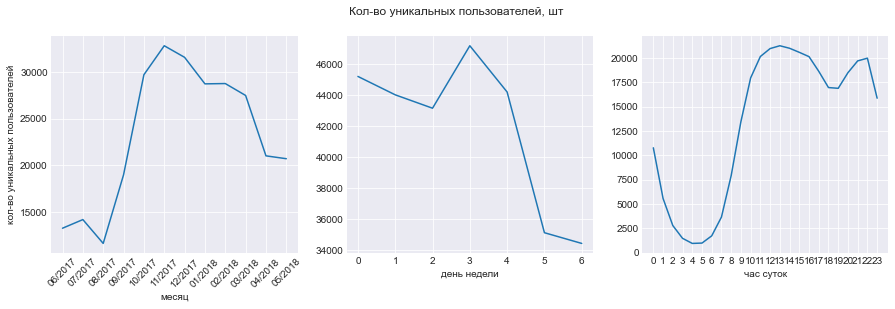

In [15]:
print('{:.0f} людей пользуются сервисом в месяц'.format(mau['unique_users'].mean()))
print('{:.0f} людей пользуются сервисом в неделю'.format(wau['unique_users'].mean()))
print('{:.0f} людей пользуются сервисом в день'.format(dau['unique_users'].mean()))

x1 = mau['start_ts_month'].dt.strftime("%m/%Y")
y1 = mau['unique_users']
x2 = visits_weekday['start_ts_weekday'].apply(str)
y2 = visits_weekday['unique_users']
x3 = visits_hour['start_ts_hour'].apply(str)
y3 = visits_hour['unique_users']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 4))
fig.suptitle('Кол-во уникальных пользователей, шт')

ax1.plot(x1, y1)
ax1.set_xlabel('месяц')
ax1.set_xticklabels(labels = x1, rotation = 45)
ax1.set_ylabel('кол-во уникальных пользователей')

ax2.plot(x2, y2)
ax2.set_xlabel('день недели')

ax3.plot(x3, y3)
ax3.set_xlabel('час суток')

plt.show();

Кол-во уникальных пользователей сервиса с touch девайсов:
6826 в среднем в месяц
1666 в среднем в неделю
253 в среднем в день

Кол-во уникальных пользователей сервиса с desktop девайсов:
16725 в среднем в месяц
4208 в среднем в неделю
659 в среднем в день



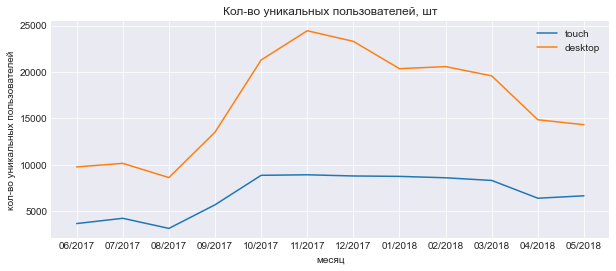

In [16]:
#считаю кол-во уникальных посетителей в месяц/неделю/день в разбивке по типу девайса
for device in visits['device'].unique():
    device_mau = (visits[visits['device'] == device]
           .groupby(['start_ts_month'])
           .agg(unique_users = ('uid', 'nunique'))
           .reset_index())
    device_wau = (visits[visits['device'] == device]
           .groupby(['start_ts_week'])
           .agg(unique_users = ('uid', 'nunique'))
           .reset_index())
    device_dau = (visits[visits['device'] == device]
           .groupby(['start_ts_date'])
           .agg(unique_users = ('uid', 'nunique'))
           .reset_index())
    
    print('Кол-во уникальных пользователей сервиса с {} девайсов:'.format(device))
    print('{:.0f} в среднем в месяц'.format(device_mau['unique_users'].mean()))
    print('{:.0f} в среднем в неделю'.format(device_wau['unique_users'].mean()))
    print('{:.0f} в среднем в день'.format(device_dau['unique_users'].mean()))
    print()
    
    plt.title('Кол-во уникальных пользователей, шт')
    device_mau['unique_users'].plot(figsize = (10,4))
    plt.xticks(np.arange(len(device_mau['start_ts_month'])), labels = device_mau['start_ts_month'].dt.strftime("%m/%Y"))
    plt.ylabel('кол-во уникальных пользователей')
    plt.xlabel('месяц')
    plt.legend(['touch', 'desktop']);

За последний год в среднем у сервиса 23228 уникальных пользователей в месяц. Минимальное кол-во людей пользуется сервисом летом (<15т человек в месяц), максимальное - в Ноябре-Декабре (>30т человек в месяц). Около трети уникальных пользователей заходит с touch девайсов, а основная часть с desktop.   

В среднем 5825 людей пользуются сервисом в неделю, максимум посетителей наблюдается в Четверг (люди смотрят варианты досуга на выходные?), минимум - в выходные (собственно занимаются тем досугом, который нашли?)

В среднем 908 уникальных пользователей у сервиса в день - больше всего в середине дня 12-13ч (в обед?) и вечером 21-22ч (перед сном?).

#### Сколько сессий происходило в день

In [17]:
daily_sessions = (visits
                  .groupby(['start_ts_date'])
                  .agg(unique_users = ('uid', 'count'))
                  .reset_index())

daily_sessions['user_sessions'] = daily_sessions['unique_users'] / dau['unique_users']

print('У сервиса всего {:.0f} сессий в день в среднем за последний год,'.format(daily_sessions['unique_users'].mean()))
print('то есть в среднем у одного пользователя {:.2f} сессий в день'.format(daily_sessions['user_sessions'].mean()))

У сервиса всего 987 сессий в день в среднем за последний год,
то есть в среднем у одного пользователя 1.08 сессий в день


In [18]:
for device in visits['device'].unique():
    device_daily_sessions = (visits[visits['device'] == device]
                      .groupby(['start_ts_date'])
                      .agg(unique_users = ('uid', 'count'))
                      .reset_index())
    device_daily_sessions['user_sessions'] = device_daily_sessions['unique_users'] / device_dau['unique_users']

    print('Кол-во сессий в день с {} девайсов:'.format(device))
    print('{:.0f} сессий в среднем за последний год, то есть у одного пользователя {:.2f} сессий в день'
          .format(device_daily_sessions['unique_users'].mean(),
                  device_daily_sessions['user_sessions'].mean()))
    print()

Кол-во сессий в день с touch девайсов:
267 сессий в среднем за последний год, то есть у одного пользователя 0.92 сессий в день

Кол-во сессий в день с desktop девайсов:
721 сессий в среднем за последний год, то есть у одного пользователя 1.09 сессий в день



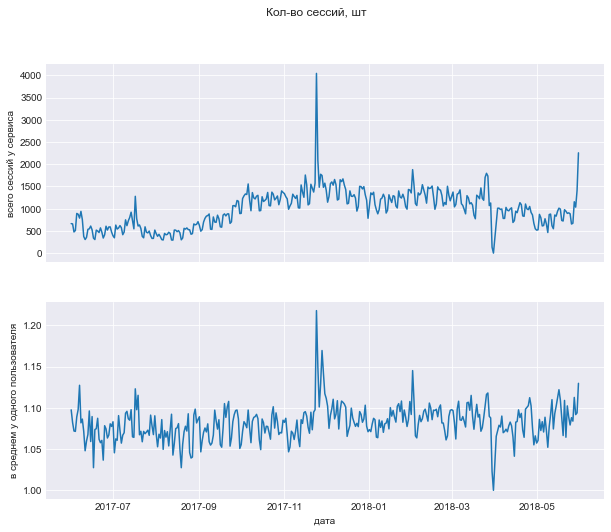

In [19]:
x = daily_sessions['start_ts_date']
y1 = daily_sessions['unique_users']
y2 = daily_sessions['user_sessions']

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize = (10, 8))
fig.suptitle('Кол-во сессий, шт')

ax1.plot(x, y1)
ax1.set_ylabel('всего сессий у сервиса')

ax2.plot(x, y2)
ax2.set_xlabel('дата')
ax2.set_ylabel('в среднем у одного пользователя')

plt.show();

У сервиса всего 987 сессий в день в среднем за последний год, то есть в среднем у одного пользователя 1.08 сессий в день. Максимальное количество сессий происходит в Декабре (1.2 сессии в день).

Пользователи с desktop девайсов чуть чаще заходят на сервис: 1.09 сессий в день против 0.92 сессий у пользователей touch.

#### Сколько длится одна сессия

In [20]:
#считаю длительность каждой сессии
visits['session_length'] = visits['end_ts'] - visits['start_ts']

In [21]:
visits['session_length'].describe()

count                    359400
mean     0 days 00:10:43.025687
std      0 days 00:16:37.127760
min           -1 days +23:14:00
25%             0 days 00:02:00
50%             0 days 00:05:00
75%             0 days 00:14:00
max             0 days 11:51:00
Name: session_length, dtype: object

В данных 2 сессии с отрицательной длительностью - думаю это ошибка и их правильно будет удалить

In [22]:
visits = visits[visits['session_length'] > '0 days']

Медиана длительности сессии для touch девайсов: 4.0 минут
Медиана длительности сессии для desktop девайсов: 7.0 минут


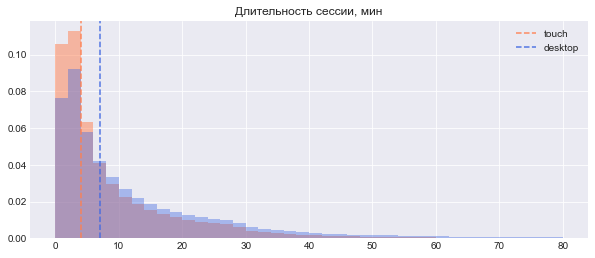

In [23]:
touch = (pd.to_timedelta(visits[visits['device'] == 'touch']['session_length']) / np.timedelta64(1, 'm'))
desktop = (pd.to_timedelta(visits[visits['device'] == 'desktop']['session_length']) / np.timedelta64(1, 'm'))

print('Медиана длительности сессии для touch девайсов:', touch.median(), 'минут')
print('Медиана длительности сессии для desktop девайсов:', desktop.median(), 'минут')

plt.figure(figsize=(10, 4))
plt.title('Длительность сессии, мин')
touch.hist(alpha=0.5, density = 1, bins = 40, color = 'coral', range = (0,80))
desktop.hist(alpha=0.4, density = 1, bins = 40, color = 'royalblue', range = (0,80))
plt.axvline(touch.median(), color='coral', alpha=0.9, linestyle='dashed')
plt.axvline(desktop.median(), color='royalblue', alpha=0.9, linestyle='dashed')
plt.legend(['touch', 'desktop']);

В среднем одна сессия длится около 5ти минут: для desktop устройств чуть дольше (7 минут), чем для touch (4 минуты).

#### Как часто люди возвращаются

In [24]:
#создаю таблицу с месяцем первой сессии пользователя
first_session_month = (visits
                       .groupby(['uid'])
                       .agg(first_session_month = ('start_ts_month', 'min'))
                       .reset_index()
                      )

In [25]:
#добавляю инфо о месяце первой сессии в таблицу с посещениями и считаю lifetime
visits = visits.merge(first_session_month, on='uid', how = 'left')
visits['lifetime'] = ((visits['start_ts_month'] - visits['first_session_month']) / np.timedelta64(1, 'M')).round()

In [26]:
#формирую когорты по месяцу первой сессии и lifetime
cohorts = (visits
           .groupby(['first_session_month','lifetime'])
           .agg(unique_users = ('uid','nunique'))
           .reset_index()
          )

In [27]:
#считаю кол-во уникальных пользователей в когортах
cohort_users = cohorts[cohorts['lifetime'] == 0][['first_session_month', 'unique_users']].reset_index(drop = True)
cohort_users = cohort_users.rename(columns={'unique_users':'cohort_users'})
cohorts = cohorts.merge(cohort_users, on='first_session_month')

In [28]:
#считаю % пользователей из когорты, которые совершили повторный визит
cohorts['retention'] = cohorts['unique_users'] / cohorts['cohort_users']

In [29]:
retention_pivot = (cohorts
                   .pivot_table(index='first_session_month',
                                columns='lifetime',
                                values='retention',
                                aggfunc='sum'))
retention_pivot.index = retention_pivot.index.strftime("%m/%Y")

Средний RR:


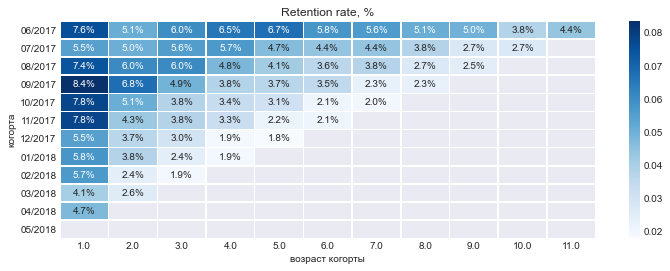

In [30]:
print('Средний RR:')
display(retention_pivot.mean(axis = 0).to_frame().T.style.format("{:.1%}"))

plt.figure(figsize=(12, 4))
plt.title('Retention rate, %')
sns.heatmap(retention_pivot.iloc[:, 1:], annot=True, fmt='.1%', linewidths=0.5, linecolor='white', cmap="Blues")
plt.ylabel('когорта')
plt.xlabel('возраст когорты');

В среднем только 6.4% пользователей возвращаются на следующий месяц после первого визита и с каждой следующей когортой RR падает: с 7.6% в когорте 06/2017 до 4.7% в когорте 04/2018. Возможно, имеет смысл пересмотреть маркетинговую стратегию

<a href="#back">В начало</a>

<article id="part22">
<h3>Шаг 2.2 Продажи
</article>

#### Когда люди начинают покупать?

In [31]:
#создаю таблицу с информацией о первой покупке пользователя
first_purch_info = (orders
                     .groupby(['uid'])
                     .agg(first_purch_date = ('buy_ts_date', 'min'))
                     .reset_index()
                    )
#добавляю месяц к дате первой покупки каждого пользователя
first_purch_info['first_purch_month'] = (pd.to_datetime(first_purch_info['first_purch_date'])
                                         .values
                                         .astype('datetime64[M]'))

In [32]:
#добавляю дату первой покупки в таблицу с визитами
visits = visits.merge(first_purch_info, on='uid', how = 'left')

In [33]:
#считаю сколько сессий прошло до первой покупки
sessions_to_purchase = (visits[visits['start_ts_date'] <= visits['first_purch_date']]
                        .groupby(['uid'])
                        .agg(sessions_to_purchase = ('start_ts_date', 'count'))
                        .reset_index()
                       )

In [34]:
sessions_to_purchase['sessions_to_purchase'].describe()

count   35936.00
mean        1.57
std         1.88
min         1.00
25%         1.00
50%         1.00
75%         2.00
max       150.00
Name: sessions_to_purchase, dtype: float64

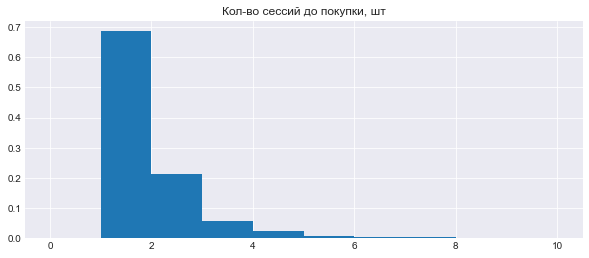

In [35]:
plt.figure(figsize=(10, 4))
plt.title('Кол-во сессий до покупки, шт')
sessions_to_purchase['sessions_to_purchase'].hist(bins = 10, range = (0, 10), density = 1);

Подавляющее большинство пользователей покупают в первую же сессию, но бывают пользователи, которые 150 раз посещают сервис до покупки

#### Построение покупательских когорт

In [36]:
#создаю таблицу с информацией о девайсе, с которого была сделана первая покупка и источнике рекламы
first_purch_dict = (visits
                      .groupby(['uid', 'first_purch_date'])
                      .agg(device = ('device', 'first'), source = ('source_id', 'first'))
                      .reset_index()
                     )

In [37]:
#добавляю информацию о девайсе в таблицу first_purch_info
first_purch_info = first_purch_info.merge(first_purch_dict[['uid', 'first_purch_date', 'device', 'source']],
                                          on=['uid', 'first_purch_date'],
                                          how = 'left')

In [38]:
#добавляю инфо о первой покупке в таблицу со всеми заказами
orders = orders.merge(first_purch_info[['uid', 'first_purch_month', 'device', 'source']], on='uid', how = 'left')

In [39]:
#считаю выручку, ср чек и кол-во заказов по когортам 
purchase_cohorts = (orders
                    .groupby(['first_purch_month','buy_ts_month'])
                    .agg(total_revenue = ('revenue', 'sum'), #для расчета ltv
                         avg_revenue = ('revenue', 'median'), #для расчета среднего чека
                         cnt_purchase =  ('revenue', 'count')) #для расчета кол-ва покупок
                    .reset_index()
                   )

In [40]:
#считаю кол-во уникальных покупателей в каждый месяц 
purchase_cohort_size = (orders
                        .groupby(['first_purch_month'])
                        .agg(unique_users = ('uid','nunique'))
                        .reset_index()
                       )
#добавляю кол-во уникальных покупателей в таблицы с когортами
purchase_cohorts = purchase_cohorts.merge(purchase_cohort_size,
                                          on='first_purch_month',
                                          how = 'left')

In [41]:
#добавляю к когортам расчетные показатели возраст когорты и кол-во заказов
purchase_cohorts['age'] = ((purchase_cohorts['buy_ts_month']
                            - purchase_cohorts['first_purch_month'])
                           / np.timedelta64(1, 'M')).round()

purchase_cohorts['cnt_purchase_per_user'] = purchase_cohorts['cnt_purchase'] / purchase_cohorts['unique_users']

#### Сколько раз покупают за период?

In [42]:
cnt_purchase_pivot = (purchase_cohorts
                      .pivot_table(index='first_purch_month',
                                   columns='age',
                                   values='cnt_purchase_per_user',
                                   aggfunc='sum')
                      .cumsum(axis=1)
                     )
cnt_purchase_pivot.index = cnt_purchase_pivot.index.strftime("%m/%Y")

В среднем один пользователь покупает 1.4 раз за 6 месяцев


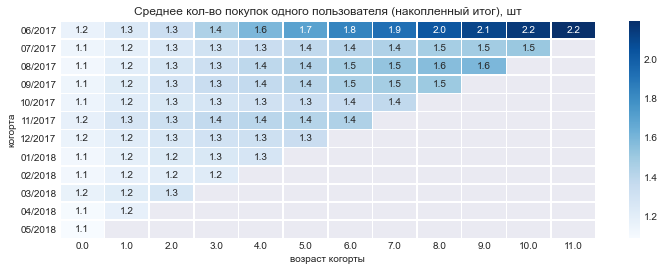

In [43]:
ltv_6m = cnt_purchase_pivot.iloc[0:7, 5:6].mean().array[0]
print('В среднем один пользователь покупает {:.1f} раз за 6 месяцев'.format(ltv_6m))

plt.figure(figsize=(12, 4))
plt.title('Среднее кол-во покупок одного пользователя (накопленный итог), шт')
sns.heatmap(cnt_purchase_pivot.iloc[:-1, :], annot=True, fmt='.1f', linewidths=0.5, linecolor='white', cmap="Blues")
plt.ylabel('когорта')
plt.xlabel('возраст когорты');

В среднем один пользователь покупает 1.4 раз за 6 месяцев, но явно выделяется когорта 06/2017, в которой пользователи покупают 1.7 раз за 6 месяцев, в остальных когортах этот показатель не выше 1.4 - возможно имеет смысл посмотреть детальнее, что поменялось в продукте или способах привлечения в следующие месяцы.

#### Какой средний чек?

Средний чек 5.00$
Средний чек для touch девайсов 4.33$
Средний чек для desktop девайсов 5.17$


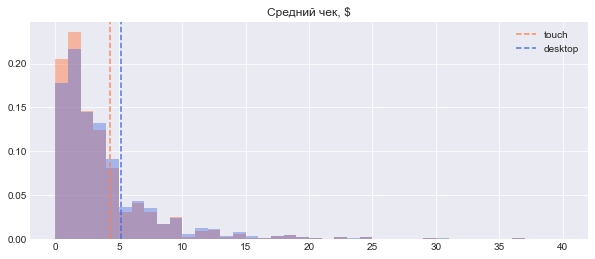

In [44]:
touch = orders[orders['device'] == 'touch']['revenue']
desktop = orders[orders['device'] == 'desktop']['revenue']

print('Средний чек {:.2f}$'.format(orders['revenue'].mean()))
print('Средний чек для touch девайсов {:.2f}$'.format(touch.mean()))
print('Средний чек для desktop девайсов {:.2f}$'.format(desktop.mean()))

plt.figure(figsize=(10, 4))
plt.title('Средний чек, $')
touch.hist(alpha=0.5, density = 1, bins = 40, color = 'coral', range = (0,40))
desktop.hist(alpha=0.4, density = 1, bins = 40, color = 'royalblue', range = (0,40))
plt.axvline(touch.mean(), color='coral', alpha=0.9, linestyle='dashed')
plt.axvline(desktop.mean(), color='royalblue', alpha=0.9, linestyle='dashed')
plt.legend(['touch', 'desktop']);

In [45]:
avg_purchase_pivot = (purchase_cohorts
                      .pivot_table(index='first_purch_month',
                                   columns='age',
                                   values='avg_revenue',
                                   aggfunc='mean')
                     )
avg_purchase_pivot.index = avg_purchase_pivot.index.strftime("%m/%Y")

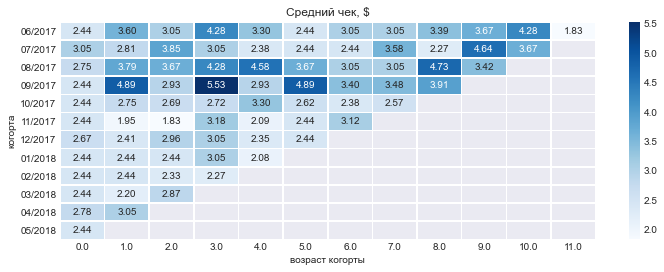

In [46]:
plt.figure(figsize=(12, 4))
plt.title('Средний чек, $')
sns.heatmap(avg_purchase_pivot.iloc[:-1, :], annot=True, fmt='.2f', linewidths=0.5, linecolor='white', cmap="Blues")
plt.ylabel('когорта')
plt.xlabel('возраст когорты');

Средний чек 5$ и в целом сохраняется стабильным по всем когортам и девайсам:
- Средний чек для touch девайсов 4.33
- Средний чек для desktop девайсов 5.17

Есть выбросы, которые скорее всего объяснимы какими-то событиями: например, в когорте 09/2017 в 3 периоде есть сильный выброс, что похоже на большую покупку для Нового года (Декабрь 2017)

#### Сколько денег приносят? (LTV)

In [47]:
#предполагаю, что маржинальность = 100%
margin_rate = 1

In [48]:
#считаю LTV как прибыдь/кол-во уникальных пользователей
purchase_cohorts['ltv'] = (purchase_cohorts['total_revenue'] * margin_rate) / purchase_cohorts['unique_users']

In [49]:
purchase_pivot = (purchase_cohorts
                  .pivot_table(index='first_purch_month',
                               columns='age',
                               values='ltv',
                               aggfunc='sum')
                  .cumsum(axis=1)
                 )
purchase_pivot.index = purchase_pivot.index.strftime("%m/%Y")

Средний LTV:


age  0.00   1.00   2.00   3.00   4.00   5.00   6.00   7.00   8.00   9.00   \
0     4.80   5.40   5.82   6.69   7.30   7.97   8.39   9.08  10.06   9.25   

age  10.00  11.00  
0    10.00  11.88

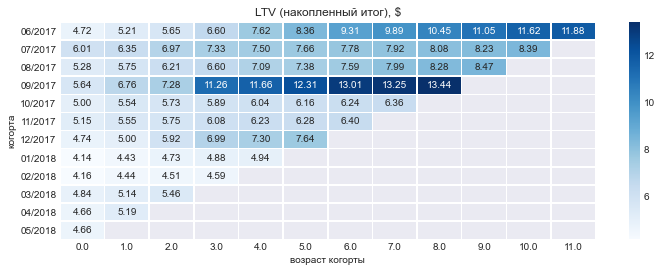

In [50]:
print('Средний LTV:')
display(purchase_pivot.mean(axis = 0).to_frame().T)
ltv_6m = purchase_pivot.mean(axis = 0)[5]

plt.figure(figsize=(12, 4))
plt.title('LTV (накопленный итог), $')
sns.heatmap(purchase_pivot.iloc[:-1, :], annot=True, fmt='.2f', linewidths=0.5, linecolor='white', cmap="Blues")
plt.ylabel('когорта')
plt.xlabel('возраст когорты');

В среднем один покупатель приносит 8$ за 6 месяцев, но основная сумма приходит в первый месяц (4.8). В целом, LTV сохраняется на уровне 4.8 с каждой следующей когортой.

Выделяется 09/2017 когорта из-за выброса в 3м периоде

<a href="#back">В начало</a>

<article id="part23">
<h3>Шаг 2.3 Маркетинг
</article>

#### Сколько денег потратили? Всего / на каждый источник / по времени

In [51]:
#считаю затраты всего/в месяц/по источникам
total_costs = costs['costs'].sum()
monthly_costs = costs.groupby('dt_month')['costs'].sum().reset_index()
source_costs = costs.groupby('source_id')['costs'].sum().reset_index()
source_monthly_costs = (costs
                        .pivot_table(index = 'dt_month', 
                                     columns = 'source_id',
                                     values = 'costs',
                                     aggfunc = 'sum')
                       )

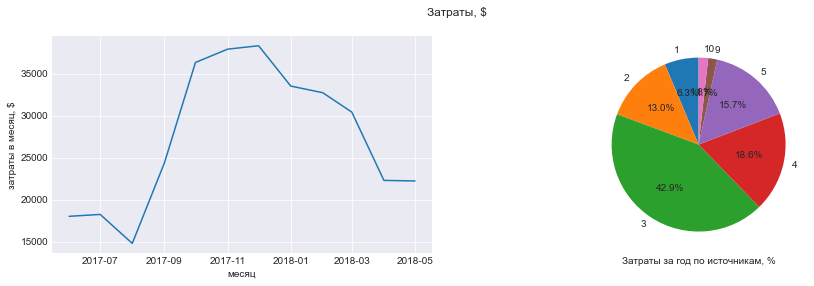

In [52]:
x1 = monthly_costs['dt_month']
y1 = monthly_costs['costs']

labels = source_costs['source_id']
size = source_costs['costs']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))
fig.suptitle('Затраты, $')

ax1.plot(x1, y1)
ax1.set_ylabel('затраты в месяц, $')
ax1.set_xlabel('месяц')

ax2.pie(size, labels=labels, autopct='%.1f%%', startangle = 90)
ax2.set_xlabel('Затраты за год по источникам, %');

За год всего было потрачено 329131.62$, с максимальными затратами в Ноябре-Декабре 2017. Основной источник №3: доля в затратах 43%

#### Сколько стоило привлечение одного покупателя из каждого источника?

In [53]:
#в таблицу с когортами добавляю инфо о затратах
purchase_cohorts = (purchase_cohorts
                    .merge(monthly_costs,
                           left_on='first_purch_month',
                           right_on = 'dt_month',
                           how = 'left')
                   )

In [54]:
#считаю сас
purchase_cohorts['cac'] = purchase_cohorts['costs'] / purchase_cohorts['unique_users']

In [55]:
#считаю сас в целом по всем источникам
total_cac = (purchase_cohorts
             .pivot_table(index='first_purch_month',
                          values='cac',
                          aggfunc='mean')
            )

In [56]:
#строю когорты с учетом источника рекламы
source_cohorts = (orders
                  .groupby(['first_purch_month', 'source'])
                  .agg(revenue = ('revenue','sum'), unique_users = ('uid','nunique'))
                  .reset_index()
                 )

In [57]:
#добавляю инфо о затратах в таблицу когорт
source_monthly_costs = (source_monthly_costs
                        .unstack()
                        .reset_index()
                        .rename(columns = {'dt_month':'first_purch_month', 'source_id':'source', 0:'costs'})
                       )

source_cohorts = source_cohorts.merge(source_monthly_costs,
                                      left_on=['first_purch_month', 'source'],
                                      right_on = ['first_purch_month', 'source'],
                                      how = 'left')

In [58]:
#считаю сас по источникам рекламы
source_cohorts['cac'] = source_cohorts['costs'] / source_cohorts['unique_users'] 

In [59]:
source_cohorts_uu = (source_cohorts.pivot_table(index = 'first_purch_month',
                                         columns = 'source',
                                         values = 'unique_users',
                                         aggfunc = 'sum'))

source_cohorts_uu.index = source_cohorts_uu.index.strftime("%m/%Y")

In [60]:
print('Среднее кол-во привлеченных пользователей в разбивке по источникам')
source_cohorts_uu.mean()

Среднее кол-во привлеченных пользователей в разбивке по источникам


source
1.00    313.42
2.00    354.08
3.00    751.67
4.00    745.38
5.00    563.17
7.00      1.00
9.00    114.67
10.00   102.17
dtype: float64

In [61]:
source_cohorts_cac = (source_cohorts.pivot_table(index = 'first_purch_month',
                                         columns = 'source',
                                         values = 'cac',
                                         aggfunc = 'sum'))
source_cohorts_cac.index = source_cohorts_cac.index.strftime("%m/%Y")

Привлечение одного покупателя в среднем обходится в 9.38$


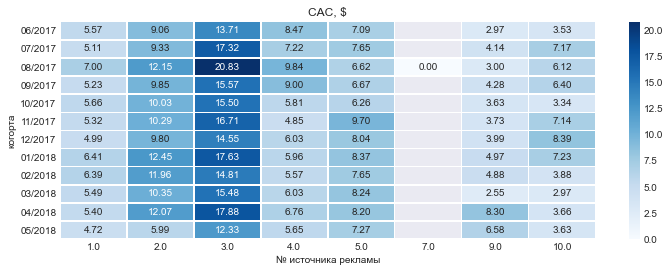

In [62]:
print('Привлечение одного покупателя в среднем обходится в {:.2f}$'.format(total_cac.iloc[:6].mean().array[0]))

plt.figure(figsize=(12, 4))
plt.title('CAC, $')
sns.heatmap(source_cohorts_cac.iloc[:-1, :], annot=True, fmt='.2f', linewidths=0.5, linecolor='white', cmap="Blues")
plt.ylabel('когорта')
plt.xlabel('№ источника рекламы');

Привлечение одного покупателя в среднем обходилось в 9.38$

Самый дорогой источник - #3. Соимость привлечения в источниках №4 и №5 намного дешевле, чем в №3, при этом в среднем за год пользователей они принесли не намного меньше. Возможно имеет смысл пересмотреть распределенеи затрат

#### На сколько окупились расходы? (ROI)

In [63]:
#рассчитываю значение roi
purchase_cohorts['roi'] = purchase_cohorts['ltv'] / purchase_cohorts['cac']

In [64]:
roi_pivot = (purchase_cohorts
             .pivot_table(index='first_purch_month',
                          columns='age',
                          values='roi',
                          aggfunc='mean')
             .cumsum(axis=1)
            )
roi_pivot.index = roi_pivot.index.strftime("%m/%Y")

Средний ROI (для когорт, проживших минимум 6 месяцев):


age  0.00   1.00   2.00   3.00   4.00   5.00   6.00   7.00   8.00   9.00   \
0     0.56   0.62   0.67   0.78   0.82   0.86   0.90   0.97   1.05   0.96   

age  10.00  11.00  
0     1.09   1.33

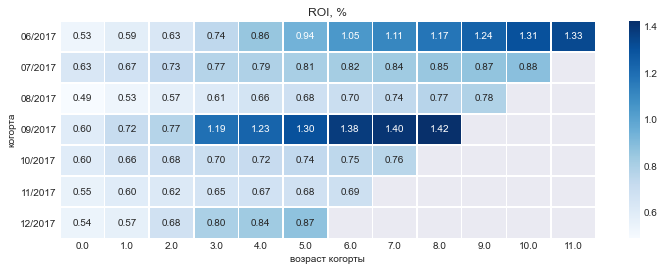

In [65]:
print('Средний ROI (для когорт, проживших минимум 6 месяцев):')
display(roi_pivot.iloc[:7, :].mean(axis = 0).to_frame().T)

plt.figure(figsize=(12, 4))
plt.title('ROI, %')
sns.heatmap(roi_pivot.iloc[:7, :], annot=True, fmt='.2f', linewidths=0.5, linecolor='white', cmap="Blues")
plt.ylabel('когорта')
plt.xlabel('возраст когорты');

На 6ой месяц когорты в среднем окупаются только на 86%, только одна когорта окупилась полностью.


<a href="#back">В начало</a>

<article id="part3">
<h3>Шаг 3. Общий вывод
</article>

Выводы:
- Всего сервисом пользуется более 23т человек в месяц, более 70% с desktop устройств.
- Наименьшее кол-во людей пользуется сервисом летом (12т человек в месяц), максимальное - в Ноябре-Декабре (28т человек в месяц).
- В среднем одна сессия длится около 5ти минут: для desktop устройств чуть дольше (7 минут), чем для touch (4 минуты). Подавляющее большинство пользователей покупают в первую же сессию.
- Средний чек стабильно держится на уровне 5уе и для desktop (5.17уе) устройств выше почти на 20%, чем для touch (4.33уе)
- В среднем только 6.4% пользователей возвращаются на следующий месяц после первого визита и в течение последнего года этот показатель снижался (с 7.6% в когорте 06/2017 до 4.7% в когорте 04/2018)
- В среднем один покупатель приносит 8уе за 6 месяцев (LTV), но основная сумма приходит в первый месяц
- За год всего было потрачено 329131.62уе. Распределение затрат по источникам сохраняется более-менее стабильной в течение года. Основной источник №3: доля в затратах 43%
- Привлечение одного покупателя в среднем обходится в 9.38уе. Самый дорогой источник - №3. Стоимость привлечения в источниках №4 и №5 намного дешевле, чем в №3, при этом в среднем за год пользователей они принесли не намного меньше


Рекомендации:

Стоимость привлечения одного покупателя в среднем за полгода обходится в 9.38уе (САС), при этом один клиент за этот же период приносит 8уе (LTV). То есть вложения в привлечение покупателей не окупаются - имеет смысл рассмотреть эту проблему более детально:
- Ориентироваться на привлечение пользователей desktop устройств (их в целом больше, у них чуть больше сессий, сессия дольше и выше средний чек, чем у пользователей touch устройств)
- В среднем только 6.4% пользователей возвращаются на следующий месяц после первого визита и этот показатель снижается в течение года - определить барьеры (что-то изменилось в продукте или каналах привлечения)
- На 6ой месяц когорты окупаются только на 86%, к 6му месяцу только одна когорта окупилась полностью - проанализировать и понять в чем проблема
- Рассмотреть снижение расходов на источник №3 в пользу источников №4 и №5


<a href="#back">В начало</a>